# Perceptron Lab





In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
import pandas as pd
from IPython.display import display

## 1. (40%) Correctly implement and submit your own code for the perceptron learning algorithm. 

### Code requirements
- Shuffle the data each epoch.
- A way to create a random train/test split. Write your own. In the future you can use the scikit-learn version if you want.
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e. do not attempt batch updates)
- Implement a stopping criteria: when your model has trained for a number of epochs with no significant improvement in accuracy, stop training. Note that the weights/accuracy do not usually change monotonically.
- Use your perceptron to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your perceptron on the Evaluation data with the same parameters, and print your final weights and accuracy.

In [2]:
class PerceptronClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self, lr=.1, shuffle=True, num_epochs=1000, tol=0.001, max_iter_no_change=5):
        """ 
            Initialize class with chosen hyperparameters.
        Args:
            lr (float): A learning rate / step size.
            shuffle: Whether to shuffle the training data each epoch. DO NOT 
            SHUFFLE for evaluation / debug datasets.
        """
        self.lr = lr
        self.shuffle = shuffle
        self.weights = None
        self.num_epochs = num_epochs
        self.tol = tol
        self.best_accuracy = 0
        self.max_iter_no_change = max_iter_no_change

    def fit(self, X, y, initial_weights=None):
        """ 
            Fit the data; run the algorithm and adjust the weights to find a 
            good solution
        Args:
            X (array-like): A 2D numpy array with the training data, excluding
            targets
            y (array-like): A 2D numpy array with the training targets
            initial_weights (array-like): allows the user to provide initial 
            weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        X = self._add_bias(X)
        self.weights = self.initialize_weights(X.shape[1]) if initial_weights is None else initial_weights
        epochs_since_no_improvement = 0
        self.scores = []
        loss = 1
        previous_loss = 1

        for epoch in range(self.num_epochs):
            previous_loss = loss

            # Train one epoch
            if self.shuffle:
                X, y = self._shuffle_data(X, y)

            for i in range(X.shape[0]):
                input = X[i, :]
                target = y[i]
                net = np.dot(input, self.weights).sum()
                output = 1 if net > 0 else 0
                chng_weight = \
                    np.multiply(input, self.lr * (target - output))
                self.weights = np.add(self.weights, chng_weight)

            # update accuracy
            local_accuracy = self.score(X[:, :-1], y)
            self.scores.append(local_accuracy)

            loss = 1 - local_accuracy

            if loss > (previous_loss - self.tol):
                epochs_since_no_improvement += 1
            else:
                self.best_accuracy = local_accuracy
                epochs_since_no_improvement = 0

            # Break if it's been a few epochs with no improvement
            if epochs_since_no_improvement >= self.max_iter_no_change:
                break

        return self

    def predict(self, X):
        """ 
            Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding 
            targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        out = np.matmul(X, self.weights)
        preds = np.where(out>0, 1, 0)
        return (preds)

    def initialize_weights(self, n):
        """ Initialize weights for perceptron. Don't forget the bias!
        Returns:
        """
        return np.random.uniform(-1e-1, 1e-1, n) # n + 1 for bias

    def score(self, X, y):
        """ 
            Return accuracy of model on a given dataset. Must implement own 
            score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        X = self._add_bias(X)
        preds = self.predict(X)
        cnt_same = 0
        for i in range(len(preds)):
            if preds[i] == y[i]:
                cnt_same += 1

        return cnt_same/len(preds)

    def train_test_split(self, X, y, prop_test=1):
        assert(0 < prop_test <= 1)

        if self.shuffle:
            X, y = self._shuffle_data(X, y)

        X_train = X[:int( len(X) * prop_test ),:]
        X_test = X[int( len(X) * prop_test ):,:]
        y_train = y[:int( len(y) * prop_test )]
        y_test = y[int( len(y) * prop_test ):]

        return X_train, y_train, X_test, y_test

    def _add_bias(self, X):
        bias_col = np.ones((X.shape[0], 1))
        return np.append(X, bias_col, 1)

    def _shuffle_data(self, X, y):
        """ 
            Shuffle the data! This _ prefix suggests that this method should 
            only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D 
            array, rather than shuffling X and y exactly the same way, 
            independently.
        """
        arr = np.concatenate((X, np.reshape(y, (len(y), 1))), axis=1)
        np.random.shuffle(arr)
        return arr[:, :-1], arr[:, -1]

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights

    def get_epochs_ran(self):
        return len(self.scores)

    def get_scores(self):
        return self.scores

## 1.1 Debug and Evaluation

Debug and Evaluate your model using the parameters below

Learning Rate = 0.1 \ 
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it] \ 
Shuffle = False \ 
Initial Weights = All zeros

---

### 1.1.1 Debug

Debug your model by running it on the [debug dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff)

Expected Results:

Accuracy = [0.88]\
Final Weights = [-0.23  0.18 -0.1 ]

In [3]:
# Load debug data
linsep = arff.loadarff('datasets/linsep2nonorigin.arff')
debugDF = pd.DataFrame(linsep[0])
debugDF['class'] = pd.to_numeric(debugDF['class'])
y = debugDF.iloc[:, -1].to_numpy()
X = debugDF.iloc[:, 0:-1].to_numpy()

# Train on debug data
perceptron = PerceptronClassifier(lr=0.1, shuffle=False,
                                  num_epochs=10,
                                  tol=-10,
                                  max_iter_no_change=20)

initial_weights = np.zeros(X.shape[1] + 1)
perceptron.fit(X, y, initial_weights=initial_weights)

# Print accuracy and weights
print("Epochs ran: {}".format(perceptron.get_epochs_ran()))
print("Score: {}".format(perceptron.score(X,y)))
print("Weights: {}".format(perceptron.get_weights()))

Epochs ran: 10
Score: 0.875
Weights: [-0.23  0.18 -0.1 ]


### 1.1.2 Evaluation

We will evaluate your model based on it's performance on the [evaluation dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff)

In [4]:
# Load evaluation data
banknote = arff.loadarff('datasets/data_banknote_authentication.arff')
banknoteDF = pd.DataFrame(banknote[0])
banknoteDF['class'] = pd.to_numeric(banknoteDF['class'])

y = banknoteDF.iloc[:, -1].to_numpy()
X = banknoteDF.iloc[:, 0:-1].to_numpy()

# Train on evaluation data
perceptron = PerceptronClassifier(lr=0.1, shuffle=False,
                                  num_epochs=10,
                                  tol=-10,
                                  max_iter_no_change=20)

initial_weights = np.zeros(X.shape[1] + 1)
perceptron.fit(X, y, initial_weights=initial_weights)

# Print accuracy and weights
print("Epochs ran: {}".format(perceptron.get_epochs_ran()))
print("Score: {0:0.3f}".format(perceptron.score(X,y)))
print("Weights: {}".format(perceptron.get_weights()))

Epochs ran: 10
Score: 0.988
Weights: [-3.80657242 -2.840821   -3.0719334  -1.4003906   4.9       ]


## 2. (30%) Classifying on linearly separable and non-linearly separable data

### 2.1 Create 2 datasets

- Both with 8 instances using 2 real valued inputs (ranging between -1 and 1) with 4 instances from each class. 
- One data set should be linearly separable and the other not.



In [24]:
# Create 2 datasets

linsep = pd.read_csv('datasets/csv/linsep.csv', 
                     header=None).to_numpy()

# y=4(x-0.5)^{2}+0.25
nonlinsep = pd.read_csv('datasets/csv/nonlinsep.csv',
                        header=None).to_numpy()

[[0.25 0.25 1.  ]
 [0.5  0.25 1.  ]
 [0.75 0.25 1.  ]
 [1.   0.25 1.  ]
 [0.25 0.75 0.  ]
 [0.5  0.75 0.  ]
 [0.75 0.75 0.  ]
 [1.   0.75 0.  ]]
[[0.205  0.5981 1.    ]
 [0.337  0.3563 1.    ]
 [0.695  0.4021 1.    ]
 [0.831  0.6882 1.    ]
 [0.4    0.8    0.    ]
 [0.4    0.6    0.    ]
 [0.6    0.6    0.    ]
 [0.6    0.8    0.    ]]


### 2.2 Train on both sets with your perceptron code (with LR=.1)

In [29]:
# Train on each dataset
X_linsep = linsep[:, 0:-1]
y_linsep = linsep[:, -1]

perceptron_linsep = PerceptronClassifier(lr=0.1, shuffle=True)
perceptron_linsep.fit(X_linsep, y_linsep)

# Print accuracy and weights
print("Epochs ran: {}" \
      .format(perceptron_linsep.get_epochs_ran()))
print("Final accuracy: {}" \
      .format(perceptron_linsep.score(X_linsep, y_linsep)))

X_nonlinsep = nonlinsep[:, 0:-1]
y_nonlinsep = nonlinsep[:, -1]

perceptron_nonlinsep = PerceptronClassifier(lr=0.1, shuffle=True)
perceptron_nonlinsep.fit(X_nonlinsep, y_nonlinsep)

# Print accuracy and weights
print("Epochs ran: {}" \
      .format(perceptron_nonlinsep.get_epochs_ran()))
print("Final accuracy: {}" \
      .format(perceptron_nonlinsep.score(X_nonlinsep, y_nonlinsep)))

Epochs ran: 8
Final accuracy: 1.0
Epochs ran: 6
Final accuracy: 0.5


### 2.3 Graph the datasets and their corresponding decision line
 
 - Graph each dataset
 - Use your trained perceptrons above to determine each dataset's decision line
 - For all graphs always label the axes!
 
![Linearly Separable Data](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/linearly_separable.png)

![Not Linearly Separable](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/not_linearly_separable.png)

C:\Users\camer\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\camer\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


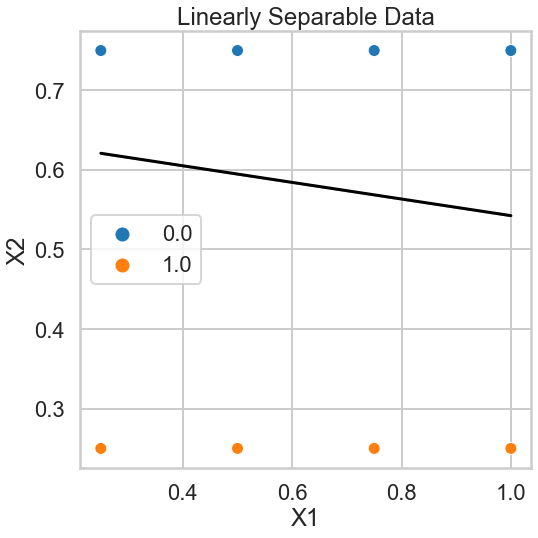

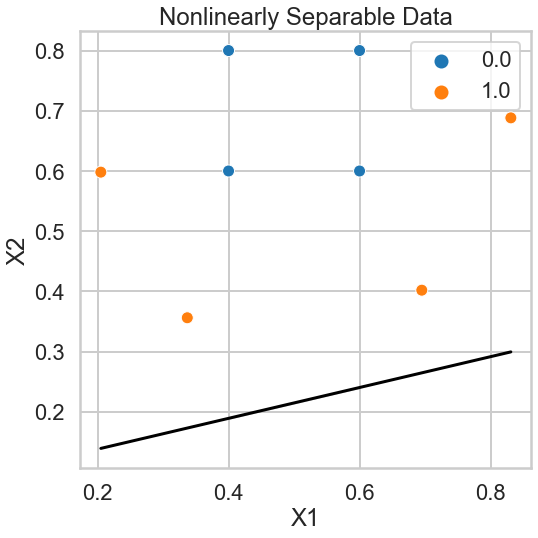

In [33]:
# Graph datasets and decision lines
sns.set_style('whitegrid')
sns.set_context('poster')

b = perceptron_linsep.get_weights()[-1]
w1 = perceptron_linsep.get_weights()[0]
w2 = perceptron_linsep.get_weights()[1]
x = X_linsep[:, 0]
y = X_linsep[:, 1]

x_intercept = -b / w1
y_intercept = -b / w2
m = -(b / w2) / (b / w1)

out = m * X_linsep[:, 0] + (-b / w2)

fig, ax = plt.subplots(figsize=(8,8))
ax = sns.scatterplot(X_linsep[:, 0], X_linsep[:, 1], hue=y_linsep)
ax = sns.lineplot(x=X_linsep[:, 0], y=out, color='black')
plt.title('Linearly Separable Data')
plt.xlabel('X1')
plt.ylabel('X2')
plt.tight_layout()
fig.savefig('decision-line-linsep.png', dpi=300)

#------------------------------------------------------------------#
b = perceptron_nonlinsep.get_weights()[-1]
w1 = perceptron_nonlinsep.get_weights()[0]
w2 = perceptron_nonlinsep.get_weights()[1]
x = X_nonlinsep[:, 0]
y = X_nonlinsep[:, 1]

x_intercept = -b / w1
y_intercept = -b / w2

if b / w1 == 0:
    m = 0
else:
    m = -(b / w2) / (b / w1)

out = m * X_nonlinsep[:, 0] + (-b / w2)

fig, ax = plt.subplots(figsize=(8,8))
ax = sns.scatterplot(X_nonlinsep[:, 0], X_nonlinsep[:, 1], hue=y_nonlinsep)
ax = sns.lineplot(x=X_nonlinsep[:, 0], y=out, color='black')
plt.title('Nonlinearly Separable Data')
plt.xlabel('X1')
plt.ylabel('X2')
plt.tight_layout()
fig.savefig('decision-line-nonlinsep.png', dpi=300)


### 2.4 Discuss why the perceptron won’t converge on non-linearly separable data.

The perceptron works by finding parameters to a linear classification function in the nth dimension.
Therefore, it can only work on data that is linearly separable and can't find an impossible line
to separate non-linearly separable data.

## 3. (20%) Use your perceptron code to learn this version of the [voting data set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting-dataset.arff).

This particular task is an edited version of the standard voting set, where we have replaced all the “don’t know” values with the most common value for the particular attribute.  

### 3.1 Create a table that reports the final training and test set accuracy and the number of epochs for each trial.

- Try it five times with different random 70/30 splits. 
- Use your own code to randomize and make splits. 
- Report the 5 trials and the average across the 5 trials in a table.  

| Trial | Training Accuracy | Test accuracy | Number of epochs |
| --- | --- | --- | --- |
| 1 | .95 | .55 | 4 |
| 2 | .85 | .45 | 6 |
| Average | .9 | .5 | 5 | 

*- As a rough sanity check, typical Perceptron test accuracies for the voting data set are 90%-98%.*


In [8]:
# Create the table any way you like
vote = arff.loadarff(r"datasets/voting-dataset.arff")
voteDF = pd.DataFrame(vote[0])
voteDF = voteDF.astype(str)

# Convert columns to classes
for column in voteDF.columns[:-1]:
    voteDF[column] = voteDF[column].astype(str)
    voteDF[column] = np.where(voteDF[column] \
                              .str \
                              .find('y') != -1, 1, 0)

# Change response column to classes. 
# democrat = 0; republican = 1
voteDF['Class'] = np.where(voteDF['Class'] \
                           .astype(str) \
                           .str \
                           .find('rep') != -1, 1, 0)

print(voteDF.info())

# Put data into np array
X_vote = voteDF.iloc[:, :-1].to_numpy()
y_vote = voteDF.iloc[:, -1].to_numpy()

vote_resultsDF = pd.DataFrame(columns=['Trial',
                                       'Training accuracy',
                                       'Test accuracy',
                                       'Number of epochs'])

# Train data on a classifier
perceptron_vote = PerceptronClassifier(lr=0.0005, 
                                       shuffle=True, 
                                       tol=1e-4, 
                                       max_iter_no_change=3)
trial_scores = []

for trial in range(5):
    X_train, y_train, X_test, y_test = \
        perceptron_vote.train_test_split(X_vote, y_vote, prop_test=0.7)
    perceptron_vote.fit(X_train, y_train)

    # Report the results of the trial
    vote_resultsDF = vote_resultsDF.append({
        'Trial': trial + 1,
        'Training accuracy': perceptron_vote.score(X_train, y_train),
        'Test accuracy': perceptron_vote.score(X_test, y_test),
        'Number of epochs': perceptron_vote.get_epochs_ran()
    }, ignore_index=True)

    # Save the scores
    trial_scores.append(perceptron_vote.get_scores())

display(vote_resultsDF)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461 entries, 0 to 460
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype
---  ------                                  --------------  -----
 0   handicapped-infants                     461 non-null    int32
 1   water-project-cost-sharing              461 non-null    int32
 2   adoption-of-the-budget-resolution       461 non-null    int32
 3   physician-fee-freeze                    461 non-null    int32
 4   el-salvador-aid                         461 non-null    int32
 5   religious-groups-in-schools             461 non-null    int32
 6   anti-satellite-test-ban                 461 non-null    int32
 7   aid-to-nicaraguan-contras               461 non-null    int32
 8   mx-missile                              461 non-null    int32
 9   immigration                             461 non-null    int32
 10  synfuels-corporation-cutback            461 non-null    int32
 11  education-spending 

,Trial,Training accuracy,Test accuracy,Number of epochs
0,1.0,0.947205,0.964029,23.0
1,2.0,0.965839,0.964029,55.0
2,3.0,0.925466,0.928058,22.0
3,4.0,0.965839,0.928058,40.0
4,5.0,0.947205,0.906475,17.0


In [9]:
print("Averages")
display(vote_resultsDF[['Training accuracy', 'Test accuracy', 'Number of epochs']].mean())
mean_test_accuracy = vote_resultsDF['Test accuracy'].mean()

# Print weights
np.set_printoptions(precision=4, suppress=True)
weights = perceptron_vote.get_weights()[:-1] # without bias

print("Final weights: \n\t{}".format(weights))

Averages


Training accuracy     0.950311
Test accuracy         0.938129
Number of epochs     31.400000
dtype: float64

Final weights: 
	[-0.0384  0.0153 -0.019   0.0691  0.0367 -0.0321  0.0233  0.0194 -0.0407
  0.0447 -0.0182 -0.0199  0.0353  0.0429  0.0243 -0.018 ]


### 3.2 By looking at the weights, explain what the model has learned and how the individual input features affect the result. Which specific features are most critical for the voting task, and which are least critical? 


The model has learned which input features are the most important in classifying whether the representative
belongs to the democratic or republican party. To determine the most important features, I filtered those whose
absolute value weights are greater than the 75th quantile of absolute value weights. Likewise, to determine the least important features, I filtered those
whose absolute value weights are less than the 25th quantile of absolute value weights.

In [10]:
abs_weights = np.abs(weights)
important_factors = np.where(abs_weights > np.quantile(abs_weights, 0.75))[0] # Where the weight is bigger than the mean of abs weights
nonimportant_factors = np.where(abs_weights < np.quantile(abs_weights, 0.25))[0]

print("Most significant features (above the 75th quantile):")
for ind in important_factors:
    print("\t{}".format(voteDF.columns[ind]))

print("Least significant features (below the 25th quantile):")
for ind in nonimportant_factors:
    print("\t{}".format(voteDF.columns[ind]))

Most significant features (above the 75th quantile):
	physician-fee-freeze
	mx-missile
	immigration
	crime
Least significant features (below the 25th quantile):
	water-project-cost-sharing
	adoption-of-the-budget-resolution
	synfuels-corporation-cutback
	export-administration-act-south-africa


### 3.3 Make a graph of the average misclassification rate vs epochs (0th – final epoch).

- Average the misclassification rate for the training set across your 5 trials (not across 5 epochs).


![Average Misclassification Rate](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/avg_misclassification_rate_vs_epochs.png)

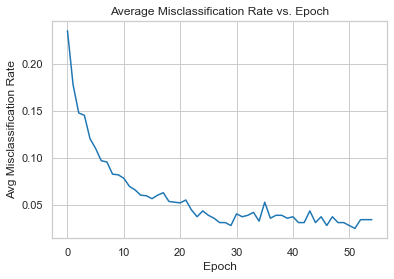

In [42]:
# Graph here
vote_scoresDF = pd.DataFrame(columns=['Trial', 'Training accuracy'])
for trial_num in range(len(trial_scores)):
    for epoch in range(len(trial_scores[trial_num])):
        vote_scoresDF = vote_scoresDF.append({
            'Trial': trial_num,
            'Training accuracy': trial_scores[trial_num][epoch],
            'Number of epochs': epoch
        }, ignore_index=True)

vote_scoresDF['Misclassification Rate Training'] = 1 - vote_scoresDF['Training accuracy']
avg_misclassification_rate = \
    vote_scoresDF.groupby('Number of epochs').agg(np.mean)['Misclassification Rate Training']

sns.set_context('notebook')

def plot_misclassification(avg_misclassification_rate):
    """
        Plots the average misclassification rate
    Args:
        avg_misclassification_rate (array-like): A 1D array or list
    """
    plt.plot(np.arange(len(avg_misclassification_rate)), avg_misclassification_rate)
    plt.title("Average Misclassification Rate vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Avg Misclassification Rate")
    plt.show()

plot_misclassification(avg_misclassification_rate)



## 4.1 (5%) Use the perceptron algorithm from the [scikit-learn toolkit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) to learn the voting task above.
- Report and compare your results with your own perceptron code.

In [51]:
# Load sklearn perceptron
perceptron_sklearn = Perceptron()

# Train on voting dataset
X_train, X_test, y_train, y_test = \
    train_test_split(X_vote, y_vote, test_size=0.3)
perceptron_sklearn.fit(X_train, y_train)
sklearn_test_accuracy = perceptron_sklearn.score(X_test, y_test)

# Print results
print("My implementation test accuracy: {0:0.3f}" \
      .format(mean_test_accuracy))
print("SciKit-Learn test accuracy: {0:0.3f}" \
      .format(sklearn_test_accuracy))

My implementation test accuracy: 0.938
SciKit-Learn test accuracy: 0.928


Depending on how the data is shuffled, my implementation and the SciKit-Learn perceptron are generally
very close in accuracy.

## 4.2 (5%) Use the perceptron algorithm from the [scikit-learn toolkit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) to learn one other data set of your choice.
- Try out some of the hyper-parameters that scikit-learn makes available.

In [55]:
# Hyperparameters to try
penalty_opt = [None,'l2','l1', 'elasticnet'] # default: None
alpha_opt = np.linspace(1e-4, 1e-1, 10) # default: 1e-4
tol_opt = np.linspace(1e-4, 1e-1, 10) # default: 1e-3
validation_fraction_opt = np.linspace(0.001, 0.2, 10) # default: 0.1
n_iter_no_change_opt = np.linspace(1, 20, 10) # default: 5
random_state = 1 # for reproducible output

X_train, X_test, y_train, y_test = \
    train_test_split(X_vote,
                     y_vote,
                     test_size=0.3,
                     random_state=random_state)

best_model = Perceptron(random_state=random_state)
best_model.fit(X_train, y_train)
base_accuracy = best_model.score(X_test, y_test)

# Train on your dataset
for penalty in penalty_opt:
    for alpha in alpha_opt:
        for tol in tol_opt:
            for validation_fraction in validation_fraction_opt:
                for n_iter_no_change in n_iter_no_change_opt:
                    curr_model = \
                        Perceptron(penalty=penalty, 
                                   alpha=alpha, 
                                   tol=tol,
                                   validation_fraction=validation_fraction,
                                   n_iter_no_change=n_iter_no_change,
                                   random_state=random_state)
                    curr_model.fit(X_train, y_train)

                    if curr_model.score(X_test, y_test) > \
                            best_model.score(X_test, y_test):
                        best_model = curr_model
                        best_penalty = penalty
                        best_alpha = alpha
                        best_tol = tol
                        best_validation_fraction = validation_fraction
                        best_n_iter_no_change = n_iter_no_change

With the hyperparameters tested, the best performing ones are listed here.

In [54]:
print("Base accuracy: {0:0.3f}".format(base_accuracy))
print("Best accuracy: {0:0.3f}".format(best_model.score(X_test, y_test)))
print("best_penalty: {}".format(best_penalty))
print("best_alpha: {}".format(best_alpha))
print("best_tol: {}".format(best_tol))
print("best_validation_fraction: {}".format(best_validation_fraction))
print("best_n_iter_no_change: {}".format(int(best_n_iter_no_change)))

Base accuracy: 0.964
Best accuracy: 0.978
best_penalty: l2
best_alpha: 0.0001
best_tol: 0.0001
best_validation_fraction: 0.001
best_n_iter_no_change: 15


## 5. (Optional 5% extra credit) Use the perceptron rule to learn the [iris task](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff) or some other task with more than two possible output values. 

Note that the [iris data](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff) set has 3 output classes, and a perceptron node only has two possible outputs.  You could implement either of the two most common ways to deal with this. For testing you just execute the novel instance on each model and combine the overall results to see which output class wins.